# Posterior distribution of fitted NMR parameters by Markov Chain Monte Carlo (MCMC) 
------------------------------------------------------------------------------------------------

**Author: He (Jason) Sun**

After the NMR spectrum is fitted, it is often useful to get an estimation of the reliability of the fitted NMR parameters. One of the common methods is through Monte Carlo simulation. Here we present a utility function that makes use of the Markov Chain Monte Carlo (MCMC)[1] method provided by package emcee[2] to sample the posterior distribution of the fitted NMR parameters.

Here we calculate the log-posterior probability $\ln p(F_{true} | D)$:

$\ln p(F_{true} | D) \propto \ln p(D | F_{true}) + \ln p(F_{true})$

$F_{true}$ is the NMR parameters, D is the NMR spectrum data.

$\ln p(D | F_{true})$ is the log-likelihood and $\ln p(F_{true})$ is the log-prior.

The log-likelihood function is defined as:

$\ln p(D|F_{true}) = -\frac{1}{2}\sum_n \left[\frac{(g_n(F_{true}) - D_n)^2}{s_n^2}+\ln (2\pi s_n^2)\right]$

Where $g_n(F_{true})$ is the fitted NMR spectrum data points and  $s_n$ is the standard deviation of the spectrum noise. $g_n(F_{true}) - D_n$ can be viewed as the residual of the fitted NMR spectrum. For more details of this implementation, please refer to the emcee package.

Here, we use a 31P Na2PO4 from dmfit examples as an example to demonstrate the use of this module. 

In [1]:
import csdmpy as cp
from mrsimulator.utils import get_spectral_dimensions
from mrsimulator.utils import spectral_fitting as sf
from src import mrsim_emcee
from src import name_abbrev
import matplotlib.pyplot as plt

from mrsimulator import Simulator, SpinSystem, Site
from mrsimulator.methods import BlochDecaySpectrum
from mrsimulator import signal_processing as sp
from lmfit import Minimizer, report_fit
import corner

## 1. Import the NMR spectrum data
------------------------------------------------------

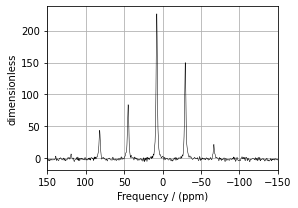

In [2]:
host = "https://nmr.cemhti.cnrs-orleans.fr/Dmfit/Help/csdm/"
filename = "31P Phosphate 6kHz.csdf"
experiment = cp.load(host + filename)

# standard deviation of noise from the dataset
sigma = 1.523217

# For spectral fitting, we only focus on the real part of the complex dataset
experiment = experiment.real

# Convert the dimension coordinates from Hz to ppm.
experiment.x[0].to("ppm", "nmr_frequency_ratio")

# plot of the dataset.
plt.figure(figsize=(4.25, 3.0))
ax = plt.subplot(projection="csdm")
ax.plot(experiment, color="black", linewidth=0.5, label="Experiment")
ax.set_xlim(150, -150)
plt.grid()
plt.tight_layout()
plt.show()

## 2. Spectrum simulation and fitting
--------------------------------------------------------------
**Note:** This section uses the same procedure as the examples showed in the fitting examples section.

**Create spinsystem**

In [3]:
P_31 = Site(
    isotope="31P",
    isotropic_chemical_shift=5.0,  # in ppm,
    shielding_symmetric={"zeta": -80, "eta": 0.5},  # zeta in Hz
)

spin_systems = [SpinSystem(sites=[P_31])]

**Create method**

In [4]:
# get the count, spectral_width, and reference_offset information from the experiment.
spectral_dims = get_spectral_dimensions(experiment)

MAS = BlochDecaySpectrum(
    channels=["31P"],
    magnetic_flux_density=9.395,  # in T
    rotor_frequency=6000,  # in Hz
    spectral_dimensions=spectral_dims,
    experiment=experiment,  # experimental dataset
)
for sys in spin_systems:
    sys.transition_pathways = MAS.get_transition_pathways(sys)

**Plot model spectrum based on guess parameters**

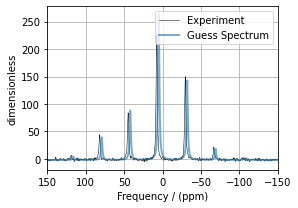

In [5]:
# Simulation
# ----------
sim = Simulator(spin_systems=spin_systems, methods=[MAS])
sim.run()

# Post Simulation Processing
# --------------------------
processor = sp.SignalProcessor(
    operations=[
        sp.IFFT(),
        sp.apodization.Exponential(FWHM="0.3 kHz"),
        sp.FFT(),
        sp.Scale(factor=300),
        sp.baseline.ConstantOffset(offset=-2),
    ]
)
processed_data = processor.apply_operations(data=sim.methods[0].simulation).real

# Plot of the guess Spectrum
# --------------------------
plt.figure(figsize=(4.25, 3.0))
ax = plt.subplot(projection="csdm")
ax.plot(experiment, color="black", linewidth=0.5, label="Experiment")
ax.plot(processed_data, linewidth=2, alpha=0.6, label="Guess Spectrum")
ax.set_xlim(150, -150)
plt.legend()
plt.grid()
plt.tight_layout()
plt.show()

**Set up LMfit params with make_LMFIT_params()**

In [6]:
params = sf.make_LMFIT_params(sim, processor, include={"rotor_frequency"})
params.pop('sys_0_abundance')
print(params.pretty_print(columns=["value", "min", "max", "vary", "expr"]))

Name                                       Value      Min      Max     Vary     Expr
SP_0_operation_1_Exponential_FWHM            0.3     -inf      inf     True     None
SP_0_operation_3_Scale_factor                300     -inf      inf     True     None
SP_0_operation_4_ConstantOffset_offset        -2     -inf      inf     True     None
mth_0_rotor_frequency                       6000     5900     6100     True     None
sys_0_site_0_isotropic_chemical_shift          5     -inf      inf     True     None
sys_0_site_0_shielding_symmetric_eta         0.5        0        1     True     None
sys_0_site_0_shielding_symmetric_zeta        -80     -inf      inf     True     None
None


**Solve the minimizer with LMfit and plot the fitted curve/residual**

In [7]:
minner = Minimizer(sf.LMFIT_min_function, params, fcn_args=(sim, processor, sigma))
result = minner.minimize()
report_fit(result)

[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 99
    # data points      = 2048
    # variables        = 7
    chi-square         = 2364.72004
    reduced chi-square = 1.15860855
    Akaike info crit   = 308.494070
    Bayesian info crit = 347.866403
[[Variables]]
    sys_0_site_0_isotropic_chemical_shift:   7.57609722 +/- 0.00347983 (0.05%) (init = 5)
    sys_0_site_0_shielding_symmetric_zeta:  -88.1881090 +/- 0.20973014 (0.24%) (init = -80)
    sys_0_site_0_shielding_symmetric_eta:    0.45591098 +/- 0.01141672 (2.50%) (init = 0.5)
    mth_0_rotor_frequency:                   6012.45935 +/- 0.80711589 (0.01%) (init = 6000)
    SP_0_operation_1_Exponential_FWHM:       0.27280282 +/- 0.00163466 (0.60%) (init = 0.3)
    SP_0_operation_3_Scale_factor:           268.854044 +/- 1.20048651 (0.45%) (init = 300)
    SP_0_operation_4_ConstantOffset_offset: -1.65291838 +/- 0.03734295 (2.26%) (init = -2)
[[Correlations]] (unreported correlations are < 0.100)
    C(SP

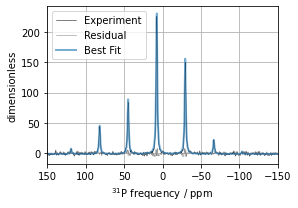

In [8]:
# Best fit spectrum/residual plotting
best_fit = sf.bestfit(sim, processor)[0]
residuals = sf.residuals(sim, processor)[0]

plt.figure(figsize=(4.25, 3.0))
ax = plt.subplot(projection="csdm")
ax.plot(experiment, color="black", linewidth=0.5, label="Experiment")
ax.plot(residuals, color="gray", linewidth=0.5, label="Residual")
ax.plot(best_fit, linewidth=2, alpha=0.6, label="Best Fit")
ax.set_xlabel(r"$^{31}$P frequency / ppm")
ax.set_xlim(150, -150)
plt.legend()
plt.grid()
plt.tight_layout()
plt.show()

## 3. MCMC sampling and ploting of the posterior distribution
-----------------------------------------------------------------------------------------

**Create an mrsim_emcee object with fitted NMR parameters, Simulator and Processor**

In [9]:
mcmc_calc = mrsim_emcee(result.params, sim, processor, sigma=sigma)

**Setup args for mcmc simulation**

`nwalkers` Should be set so nwalkers >> len(result.params).Walkers are the members of the ensemble. They are almost like separate Metropolis-Hastings chains but, of course, the proposal distribution for a given walker depends on the positions of all the other walkers in the ensemble.' - from the `emcee` webpage.
          
`steps` How many samples you would like to draw from the posterior distribution for each of the walkers?

`burn` Discard this many samples from the start of the sampling regime. The first few steps of the chain when the walker is walking into the center of the posterior distribution function is called "burn-in". "burn-in" dose not correctly represent the posterior distribution function.

`thin` Only accept 1 in every `thin` samples.


In [10]:
steps = 1000
nwalkers = 25
burn = 100
thin = 20
chain = mcmc_calc.mcmc(steps, nwalkers, burn, thin)

100%|██████████| 1000/1000 [05:27<00:00,  3.05it/s]


In [11]:
# result parameters
chain['variables']

name,value,standard error,relative error,initial value,min,max,vary
sys_0_site_0_isotropic_chemical_shift,7.57573070,0.00317498,(0.04%),5.0,-inf,inf,True
sys_0_site_0_shielding_symmetric_zeta,-88.2031580,0.18841673,(0.21%),-80.0,-inf,inf,True
sys_0_site_0_shielding_symmetric_eta,0.45496767,0.00992824,(2.18%),0.5,0.00000000,1.00000000,True
mth_0_rotor_frequency,6012.47551,0.78664123,(0.01%),6000.0,5900.00000,6100.00000,True
SP_0_operation_1_Exponential_FWHM,0.27284529,0.00149086,(0.55%),0.3,-inf,inf,True
SP_0_operation_3_Scale_factor,268.811853,1.10736669,(0.41%),300.0,-inf,inf,True
SP_0_operation_4_ConstantOffset_offset,-1.65277783,0.03497707,(2.12%),-2.0,-inf,inf,True


**Ploting the posterior distributions**

Use `corner` to plot the poterior distribution of the NMR parameters.

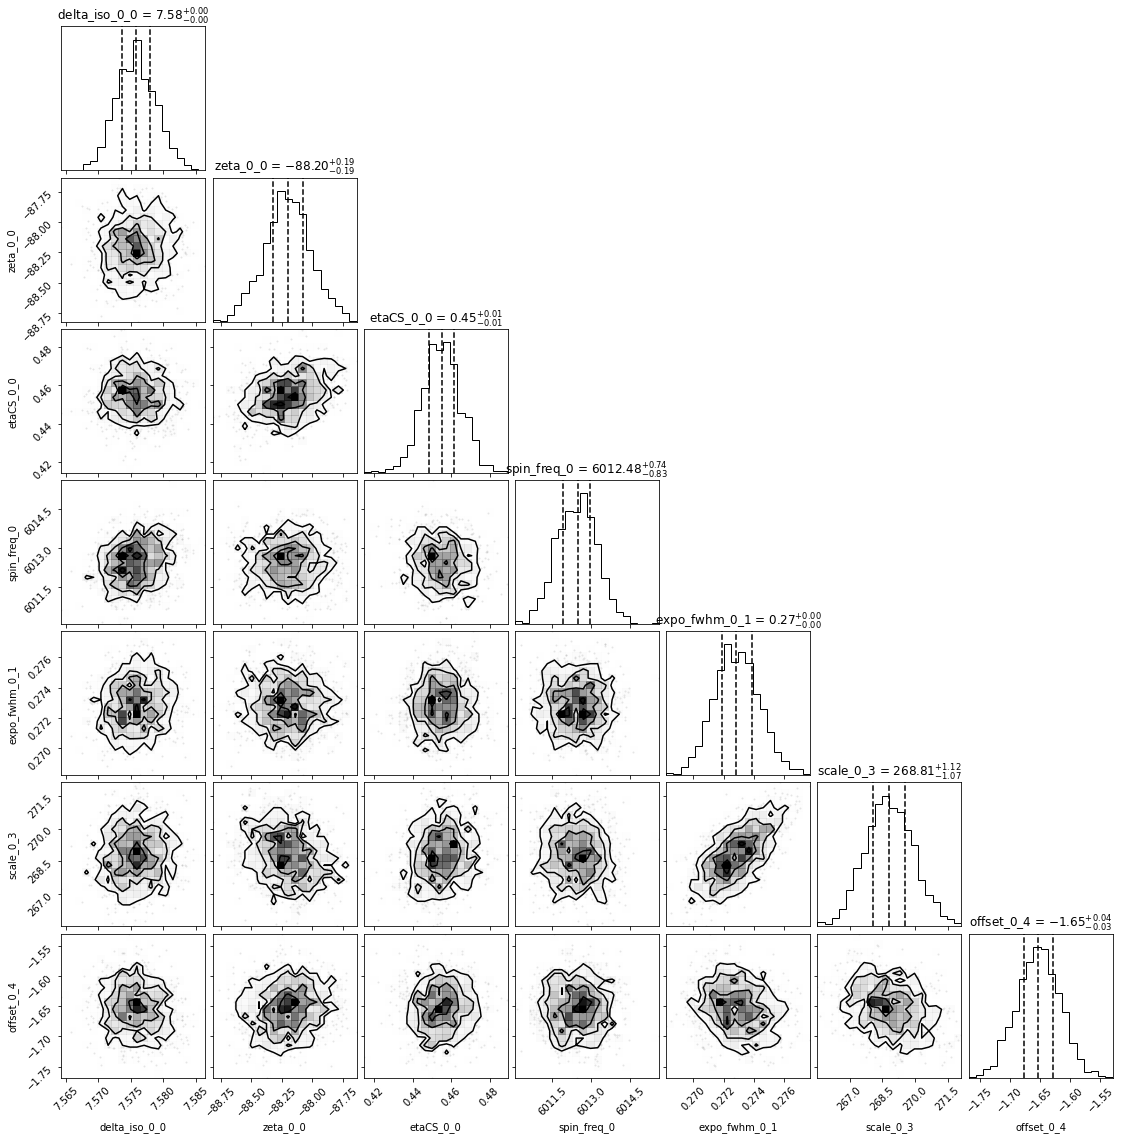

In [12]:
# Abbreviate the long param names shorter name_abbrev
variables_name = name_abbrev(chain['variables'])
fig = corner.corner(chain['flat_chain'],labels=variables_name,quantiles=[0.25, 0.5, 0.75],show_titles=True)

**Reference**
____________________________________________________________________________________________
[1] Hou, F., Goodman, J., Hogg, D. W., Weare, J., & Schwab, C. (2012). An affine-invariant sampler for exoplanet fitting and discovery in radial velocity data. The Astrophysical Journal, 745(2), 198.

[2] Foreman-Mackey, D., Hogg, D. W., Lang, D., & Goodman, J. (2013). emcee: the MCMC hammer. Publications of the Astronomical Society of the Pacific, 125(925), 306.